In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp


from torch.utils.data import DataLoader , TensorDataset
# from torch.utils.data import Dataset
import matplotlib
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import json
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


In [2]:
def load_data(filename, device, label):
    datas = []
    with open(filename, 'r') as outfile:
        json_data = json.load(outfile)
        for frame in json_data:
            frame_data = json.loads(frame)
            data = []
            for _, landmark_data in frame_data.items():
                data.extend([
                    landmark_data['x'],
                    landmark_data['y'],
                    landmark_data['z'],
                    landmark_data['visibility']
                ])
            datas.append(data)

    data_tensor = torch.tensor(datas, device=device, dtype=torch.float32)
    labels = torch.full((data_tensor.shape[0], 1), label, device=device, dtype=torch.float32)
    
    return torch.cat((data_tensor, labels), dim=1)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_0 = load_data('Database/Running and sitting/0/0.json', device,0)
data_1 = load_data('Database/Running and sitting/1/1.json', device,1)
label = {"Sitting","Running"}
data_0_tt = torch.cat((data_0,data_0))
data_0 = torch.cat((data_0,data_0_tt))
total_data = torch.cat((data_0,data_1))
r = torch.randperm(total_data.size(0))
c = torch.arange(total_data.size(1), dtype=torch.long)
total_data = total_data[r][:, c]
total_data


# train_ratio = 0.8
# train_size = int(train_ratio * total_data.size(0))
# val_size = total_data.size(0) - train_size

# train_data, val_data = torch.utils.data.random_split(total_data, [train_size, val_size])

# train_data = torch.stack([total_data[i] for i in train_data.indices])
# val_data = torch.stack([total_data[i] for i in val_data.indices])


tensor([[ 0.8962,  0.4425, -0.1782,  ...,  0.0566,  0.0543,  0.0000],
        [ 0.5514,  0.2383, -0.3167,  ..., -0.2837,  0.4476,  1.0000],
        [ 0.8681,  0.4934,  0.2408,  ..., -0.3232,  0.4910,  0.0000],
        ...,
        [ 0.4414,  0.1374, -0.5572,  ...,  0.1411,  0.8073,  1.0000],
        [ 0.7084,  0.5419, -0.2331,  ...,  0.0695,  0.9801,  0.0000],
        [ 0.2377,  0.1131, -0.4441,  ..., -0.0919,  0.8065,  1.0000]],
       device='cuda:0')

In [5]:
X = total_data[:, :-1].cpu().numpy()
y = total_data[:, -1].cpu().numpy()

# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert back to PyTorch tensors
train_data = torch.tensor(X_train, dtype=torch.float32, device=device)
train_labels = torch.tensor(y_train, dtype=torch.float32, device=device).unsqueeze(1)
val_data = torch.tensor(X_val, dtype=torch.float32, device=device)
val_labels = torch.tensor(y_val, dtype=torch.float32, device=device).unsqueeze(1)
test_data = torch.tensor(X_test, dtype=torch.float32, device=device)
test_labels = torch.tensor(y_test, dtype=torch.float32, device=device).unsqueeze(1)

In [4]:


class Neural(nn.Module):
    def __init__(self, input_size):
        super(Neural, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

In [6]:

input_size = data_0.size(1)  
model = Neural(input_size-1).to(device=device)


In [32]:
learning_rate = 1e-4

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()
batch_size = 64
train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(val_data, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# def train_loop(dataloader, model, loss_fn, optimizer):
#     size = len(dataloader)  
#     model.train()
#     for batch, data in enumerate(dataloader):
#         X = data[:-1]
#         y = data[-1].int()
#         if (y == 0).item():
#             y =  torch.tensor([0,1], dtype=torch.float32, device=device)
#         else:
#             y =  torch.tensor([1,0], dtype=torch.float32, device=device)
#         pred = model(X)
#         loss = loss_fn(pred, y)
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         if batch % 100 == 0:
#             loss, current = loss.item(), batch * batch_size + len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



# def test_loop(dataloader, model, loss_fn):

#     model.eval()
#     size = len(dataloader)
#     num_batches = len(dataloader)
#     test_loss, correct = 0, 0
#     # count = 0
#     # count_0 = 0
    
#     with torch.no_grad():
#         for data in dataloader:
#             X = data[:-1]
#             y = data[-1].int()
#             if (y == 0).item():
#                 y =  torch.tensor([0,1], dtype=torch.float32, device=device)
#             else:
#                 y =  torch.tensor([1,0], dtype=torch.float32, device=device)

#             pred = model(X)
#             # if pred == 1:
#             #     count_0+=1
#             test_loss += loss_fn(pred, y).item()
#             correct +=  ((pred > 0.5) == y).type(torch.float).sum().item()
#     test_loss /= num_batches
#     correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.5f}%, Avg loss: {test_loss:>8f} \n")
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train_loop(train_data, model, loss_fn, optimizer)
#     test_loop(val_data, model, loss_fn)
# print("Done!")

In [33]:
epochs = 200

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ((pred > 0.5) == y).float().sum().item()
    test_loss /= len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return test_loss, accuracy

for t in range(epochs):
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss, val_accuracy = test_loop(val_loader, model, loss_fn)
    print(f"Epoch {t+1}/{epochs}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.4f}")

# Final evaluation on test set
test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_loss, test_accuracy = test_loop(test_loader, model, loss_fn)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

Epoch 1/200, Train loss: 0.6880, Val loss: 0.6826, Val accuracy: 0.6702
Epoch 2/200, Train loss: 0.6785, Val loss: 0.6745, Val accuracy: 0.7500
Epoch 3/200, Train loss: 0.6695, Val loss: 0.6663, Val accuracy: 0.7660
Epoch 4/200, Train loss: 0.6610, Val loss: 0.6578, Val accuracy: 0.7766
Epoch 5/200, Train loss: 0.6526, Val loss: 0.6487, Val accuracy: 0.7766
Epoch 6/200, Train loss: 0.6418, Val loss: 0.6392, Val accuracy: 0.7766
Epoch 7/200, Train loss: 0.6320, Val loss: 0.6280, Val accuracy: 0.7819
Epoch 8/200, Train loss: 0.6204, Val loss: 0.6160, Val accuracy: 0.7926
Epoch 9/200, Train loss: 0.6087, Val loss: 0.6031, Val accuracy: 0.7872
Epoch 10/200, Train loss: 0.5955, Val loss: 0.5898, Val accuracy: 0.7926
Epoch 11/200, Train loss: 0.5820, Val loss: 0.5757, Val accuracy: 0.7979
Epoch 12/200, Train loss: 0.5696, Val loss: 0.5615, Val accuracy: 0.7979
Epoch 13/200, Train loss: 0.5567, Val loss: 0.5474, Val accuracy: 0.8138
Epoch 14/200, Train loss: 0.5439, Val loss: 0.5335, Val accu

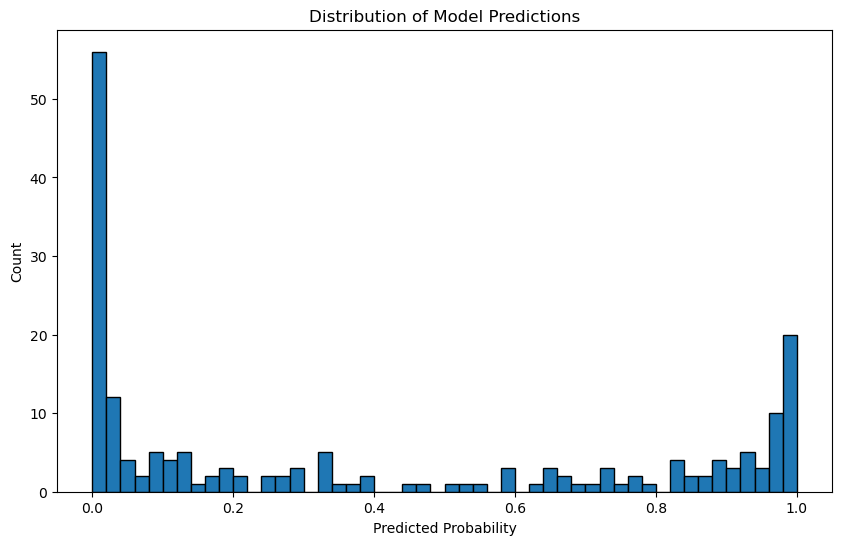

In [34]:
model.eval()
with torch.no_grad():
    val_preds = model(val_data).cpu().numpy().flatten()

plt.figure(figsize=(10, 6))
plt.hist(val_preds, bins=50, edgecolor='black')
plt.title('Distribution of Model Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.show()

In [7]:
def load_data(json_data, device):
    try:
        frame_data = json.loads(json_data)
        data = []
        for _, landmark_data in frame_data.items():
            data.extend([
                landmark_data['x'],
                landmark_data['y'],
                landmark_data['z'],
                landmark_data['visibility']
            ])
        data_tensor = torch.tensor([data], device=device, dtype=torch.float32)
        return data_tensor
    except json.JSONDecodeError as e:
        print(f"JSON Decode Error: {e}")
        print(f"Problematic JSON data: {json_data}")
        return None

video_path = './vid/usain.mp4'
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose()

cap = cv2.VideoCapture(video_path)

frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    result = pose.process(frame_rgb)

    if result.pose_landmarks:
        dic = {}
        for mark, data_point in zip(mp_pose.PoseLandmark, result.pose_landmarks.landmark):
            dic[mark.value] = {
                "landmark": mark.name,
                "x": data_point.x,
                "y": data_point.y,
                "z": data_point.z,
                "visibility": data_point.visibility
            }
        json_object = json.dumps(dic)
        
        tensor_data = load_data(json_object, device=device)
        if tensor_data is not None:
            y = model(tensor_data)
            print(f"Frame {frame_number}: Prediction = {y.item()}")
            if y.item() > 0.5:
                text = "Running"
            else:
                text = "Sitting"
        
        mp_drawing.draw_landmarks(frame, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    cv2.putText(frame, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),  2)

    cv2.imshow('MediaPipe Pose', frame)

    frame_number += 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Frame 0: Prediction = 0.4608137905597687
Frame 1: Prediction = 0.4613989591598511
Frame 2: Prediction = 0.461509644985199
Frame 3: Prediction = 0.4613552689552307
Frame 4: Prediction = 0.46139952540397644
Frame 5: Prediction = 0.46159228682518005
Frame 6: Prediction = 0.4616834819316864
Frame 7: Prediction = 0.4618320167064667
Frame 8: Prediction = 0.4617339074611664
Frame 9: Prediction = 0.4614415764808655
Frame 10: Prediction = 0.4615851640701294
Frame 11: Prediction = 0.4614320695400238
Frame 12: Prediction = 0.4616248607635498
Frame 13: Prediction = 0.4615289568901062
Frame 14: Prediction = 0.4615665376186371
Frame 15: Prediction = 0.4619067907333374
Frame 16: Prediction = 0.461957722902298
Frame 17: Prediction = 0.46194422245025635
Frame 18: Prediction = 0.46203216910362244
Frame 19: Prediction = 0.4620305299758911
Frame 20: Prediction = 0.4619731903076172
Frame 21: Prediction = 0.46190476417541504
Frame 22: Prediction = 0.4619828164577484
Frame 23: Prediction = 0.4622591137886047

KeyboardInterrupt: 

: 

In [36]:
# tb_writer = SummaryWriter()
# best_vloss = 1_000_000.


# for epoch in range(2):  
#     model.train(True)
#     running_vloss = 0.0
#     last_loss = train(epoch, tb_writer)
#     model.eval()
#     with torch.no_grad():
#         for i , v_data in enumerate(val_data):
#             label = v_data[-1]
#             if label.item() == 1:
#                 label =  torch.tensor([1], dtype=torch.float32, device=device)
#             else:
#                 label = torch.tensor([0], dtype=torch.float32, device=device)
#             v_data = v_data[:-1]
#             vout = model(v_data)
#             vloss= loss_fn(vout,label)
#             running_vloss += vloss
#     avg_vloss = running_vloss / (i + 1)
#     print('LOSS train {} valid {}'.format(last_loss, avg_vloss))

#     print(f'Epoch {epoch+1} completed with loss: {last_loss}')

# tb_writer.close()

In [38]:
torch.save(model.state_dict(), "./models/RunningSitting_v3_better.pth")
